In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import cv2
import numpy as np
import time

In [ ]:
# GPU 확인
!nvidia-smi

Wed Oct  6 12:45:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 이미지 다운로드
!mkdir /content/data
!wget -O ./data/test_image.jpg https://miro.medium.com/max/1000/1*bk6ObyKmW_uxSQJ3_zQEJA.jpeg

--2021-10-06 12:45:03--  https://miro.medium.com/max/1000/1*bk6ObyKmW_uxSQJ3_zQEJA.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.153.4, 162.159.152.4, 2606:4700:7::a29f:9804, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.153.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154993 (151K) [image/jpeg]
Saving to: ‘./data/test_image.jpg’

./data/test_image.j 100%[===================>] 151.36K  --.-KB/s    in 0.02s   

2021-10-06 12:45:03 (5.97 MB/s) - ‘./data/test_image.jpg’ saved [154993/154993]



## TF Hub에서 SSD Inference 모델 다운로드 후 Inference 수행
- 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 이미지 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요.
- inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음(4차원).
- inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요

In [ ]:
# pretrained ssd model 로딩
module_handle = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
detector_model = hub.load(module_handle)

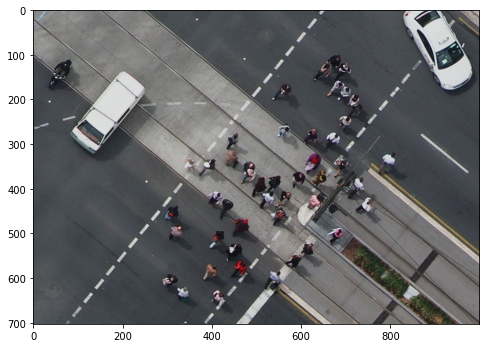

In [ ]:
img_arr = cv2.imread('/content/data/test_image.jpg')
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_arr)
plt.show()

In [ ]:
# 4차원 numpy array로 변환
img_arr_np = img_arr[np.newaxis, ...]
print(f"image shape: {img_arr_np.shape}, dtype: {img_arr_np.dtype}")

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행.
result = detector_model(img_arr_np)
print(f"inference time: {time.time()-start_time}")

image shape: (1, 703, 1000, 3), dtype: uint8
inference time: 0.04884958267211914


In [ ]:
# 4차원 tensor로 변환
img_tensor = tf.convert_to_tensor(img_arr, dtype=tf.uint8)
img_tensor = img_tensor[tf.newaxis, ...]
print(f"image shape: {img_tensor.shape}, dtype: {img_tensor.dtype}")

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행.
result = detector_model(img_tensor)
print(f"inference time: {time.time()-start_time}")

image shape: (1, 703, 1000, 3), dtype: <dtype: 'uint8'>
inference time: 0.0518651008605957


In [ ]:
result

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[ 831.,  480., 1862.,  531.,  714.,  258.,  167.,  549.,  174.,
          657.,  609.,  546.,  879.,  324.,  990.,  534.,  555.,  207.,
          666.,  987.,  648.,  381.,  432.,  699.,  540.,  537.,  660.,
          777.,  315.,  597.,  429.,  438.,  552.,  888.,  267.,  435.,
          606.,  264.,  717.,  762.,  600.,  927.,  603.,  663.,  885.,
          423.,  930.,  666.,  876.,  654.,  714.,  777.,  558.,  167.,
          759.,  110.,  819.,  296.,  210., 1760.,  477.,  609.,  492.,
          822., 1724.,  828.,  654.,  765.,  942.,  231.,  657.,  326.,
          591.,  708., 1736.,  642.,  702.,  708., 1911., 1790.,  936.,
          726.,  882.,  774.,  933.,  723.,  696.,  489.,  666.,  663.,
          353.,  939.,  495.,  324.,  777.,  831.,  879.,  720.,  474.,
          837.]], dtype=float32)>,
 'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[0.73721266,

In [ ]:
print(result.keys())
# detect 결과는 100개를 기본으로 Detect 함(즉 Detect된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위)
print(result['detection_boxes'].shape, result['detection_classes'].shape, result['num_detections'].shape, result['detection_scores'].shape)

dict_keys(['num_detections', 'detection_classes', 'detection_multiclass_scores', 'detection_anchor_indices', 'detection_boxes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_scores'])
(1, 100, 4) (1, 100) (1,) (1, 100)


In [ ]:
# detect된 object들은 detection score가 높은 순으로 array값을 순차적으로 채움. 
print('#### detection_classes #####')
print(result['detection_classes'],'\n')
print('#### detection_scores #####')
print(result['detection_scores'])

#### detection_classes #####
tf.Tensor(
[[ 1.  1.  1.  1.  1.  1. 77.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  3.  1.  1.  4.  3.  1. 75.
   1.  3.  1. 77.  1.  1.  1.  3.  1.  1.  1.  1.  4.  1.  1.  1.  4.  1.
   1.  1.  1.  1.  1. 28. 41.  1.  1.  1.  1.  1.  1.  1.  1.  1.  4.  3.
  84.  1.  1.  4.  8.  3. 10.  1.  1.  1.]], shape=(1, 100), dtype=float32) 

#### detection_scores #####
tf.Tensor(
[[0.677444   0.6642207  0.6275905  0.6187013  0.60781085 0.6017544
  0.59606063 0.5958078  0.59062433 0.58101463 0.5665838  0.5663808
  0.559792   0.55558926 0.5422876  0.5410848  0.5403648  0.54036
  0.53791845 0.53639287 0.5352442  0.5343554  0.5246403  0.5240007
  0.5191903  0.514334   0.51212674 0.49893072 0.49869356 0.49716964
  0.49372628 0.48866254 0.48672912 0.4850068  0.47916415 0.4730842
  0.47197363 0.4697252  0.46866524 0.46538043 0.46061906 0.45869517
  0.

In [ ]:
# bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함. 
# 좌표 값은 원본 이미지의 width, height로 0~1 사이값으로 정규화됨. 
print('#### detection_boxes #####')
print(result['detection_boxes'])

#### detection_boxes #####
tf.Tensor(
[[[0.73721266 0.5871197  0.80400133 0.62958324]
  [0.39050573 0.42240486 0.50233364 0.46623287]
  [0.07315832 0.09221664 0.93703276 0.8853456 ]
  [0.4755865  0.35026726 0.526221   0.3790982 ]
  [0.6257898  0.5363675  0.69380873 0.5718128 ]
  [0.23599206 0.5395342  0.28151533 0.5780008 ]
  [0.         0.8341201  0.26613784 0.9826911 ]
  [0.47426572 0.6461855  0.55566126 0.6875528 ]
  [0.16484219 0.05332366 0.24107537 0.08876418]
  [0.55840874 0.52846974 0.63536024 0.5673756 ]
  [0.53780836 0.6968405  0.5890941  0.73328996]
  [0.46060315 0.60331607 0.5403794  0.64367163]
  [0.7762426  0.44122255 0.8572984  0.48278052]
  [0.26466516 0.6900036  0.32399872 0.73832136]
  [0.89820236 0.39667398 0.9489898  0.4308433 ]
  [0.47860768 0.37316257 0.53077644 0.4037462 ]
  [0.4621963  0.76085514 0.53074163 0.8047958 ]
  [0.1532534  0.63364196 0.22987366 0.696252  ]
  [0.58877766 0.7151712  0.6446521  0.7550533 ]
  [0.87491125 0.3154396  0.9394892  0.3566558 ]
  

## inference 결과를 이미지로 시각화

In [1]:
# 1부터 91까지의 COCO Class id 매핑. 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}